# Taller 2 - ML

Integrantes:

* Jorge Díaz
* Hugo Sepúlveda

## Hipótesis

**Vecinos Pesados & Desbalanceados**: En problemas desbalanceados de clasificación, el uso de KNN con ”pesos” (inversamente proporcionales a la distancia entre el dato a predecir y los ejemplos en la respectiva vecindad) tiende a empeorar el rendimiento del modelo en las clases minoritarias.


El procedimiento seguido para los 3 dataset es:

* Análisis exploratorio, se determina clase subrepresentada, en caso de no haberla, se modifica dataset borrando algunos ejemplos.
* Se busca K óptimo, tanto para entrenamiento tradicional como con K-fold (10). Esto se hará para 3 métricas: euclideana, manhattan y chevyshev.
* Por defecto, ocuparemos el de K-fold (10).
* Se utiliza métrica minkowski con p=2.
* Se repite el proceso pero con métrica chebyshev, para contrastar métricas distintas.
* Se elige mejor métrica para el dataset.
* Se reentrena con el K óptimo y la mejor métrica.
* Se obtiene precision, recall y f1 (f-score).

El dataset 3 es tratado de otra forma, ya que además de obtener las métricas del modelo para saber su desempño con clases desbalanceadas, se compara con lo que hubiera occurido en un caso casi perfectamente balanceado.

## Importación de bibliotecas

In [59]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

random_state = 0
np.random.RandomState(random_state)

RandomState(MT19937) at 0x14129CA9B40

# Dataset 1

## Carga

In [2]:
data = pd.read_csv("datasets/sky-data.csv")
#data = data.dropna()
print(data.columns)
print(data.head(5))
print(data.shape)
print(data.isna().sum())

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')
          objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598371  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   
3  15.904

## Determinar clase subrepresentada.

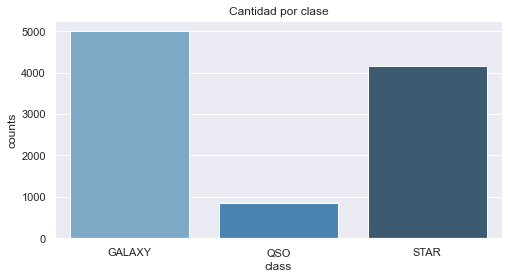

    class  counts
0  GALAXY    4998
1     QSO     850
2    STAR    4152
Respecto a clase de mayor soporte: 17.01 %
Respecto a segunda clase de menor soporte: 20.47 %


In [3]:
data = data.drop(['objid','specobjid'], axis=1)
gr = data.groupby(['class']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='class', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Cantidad por clase')
plt.show()
counts = list(gr.counts)
counts.sort()
print(gr)
print("Respecto a clase de mayor soporte:", round(counts[0] * 100 / counts[-1], 2), "%")
print("Respecto a segunda clase de menor soporte:", round(counts[0] * 100 / counts[-2], 2), "%")

Se comprueba que QSO (quasares) son la clase más subrepresentada.

## Split dataset para entrenamiento, test y evaluación

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler


cont_predictors_names = ['log_red','log_g','log_u','ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol','field', 'redshift', 'plate', 'mjd', 'fiberid']
numeric_features = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol','field', 'plate', 'mjd', 'fiberid']

classes = ['GALAXY','QSO','STAR']

X = data[numeric_features]
y = data['class']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=random_state)

y = y[:, np.newaxis]
y_train_full = y_train_full[:, np.newaxis]
y_train = y_train[:, np.newaxis]
y_val = y_val[:, np.newaxis]
y_test = y_test[:, np.newaxis]

print("X,y Shapes:", X.shape, y.shape)
print("X,y Train Full Shapes:", X_train_full.shape, y_train_full.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)
print("X,y Test Shapes:", X_test.shape, y_test.shape)

print(y_train[:10,0])

X,y Shapes: (10000, 14) (10000, 1)
X,y Train Full Shapes: (5000, 14) (5000, 1)
X,y Train Shapes: (2500, 14) (2500, 1)
X,y Val Shapes: (2500, 14) (2500, 1)
X,y Test Shapes: (5000, 14) (5000, 1)
['GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'QSO' 'QSO'
 'GALAXY' 'STAR']


## Obtención de K óptimo para entrenamiento clásico y K-fold (10)

Métrica: euclidean
	KNN peso: uniform
		Mejor K, test: 26 , acc 0.7964
		Mejor K, con K-fold (10): 23 , acc 0.7956000000000001
	KNN peso: distance
		Mejor K, test: 40 , acc 0.7926
		Mejor K, con K-fold (10): 49 , acc 0.7896000000000001


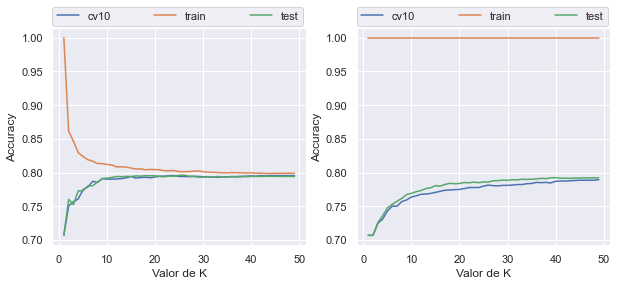



Métrica: manhattan
	KNN peso: uniform
		Mejor K, test: 26 , acc 0.7964
		Mejor K, con K-fold (10): 12 , acc 0.7971999999999999
	KNN peso: distance
		Mejor K, test: 40 , acc 0.7926
		Mejor K, con K-fold (10): 49 , acc 0.7928000000000001


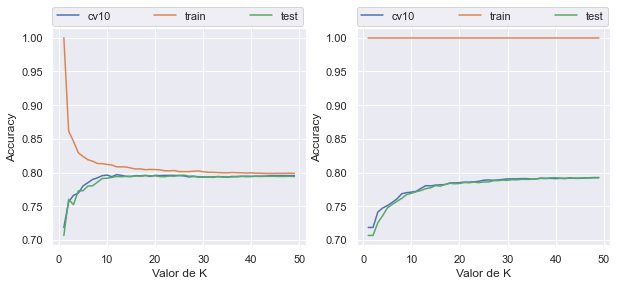



Métrica: chebyshev
	KNN peso: uniform
		Mejor K, test: 26 , acc 0.7964
		Mejor K, con K-fold (10): 41 , acc 0.7956
	KNN peso: distance
		Mejor K, test: 40 , acc 0.7926
		Mejor K, con K-fold (10): 49 , acc 0.7872000000000001


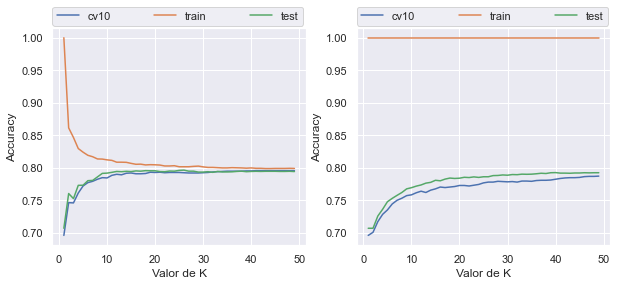

In [5]:
weights = ["uniform", "distance"]
cv = KFold(n_splits=10)

metrics = ["euclidean", "manhattan", "chebyshev"]

results = dict()

for metric in metrics:
    cv_accuracies = list([[], []])
    train_accuracies = list([[], []])
    test_accuracies = list([[], []])
    
    K_range = range(1, 50)

    best_acc_fold = [0] * len(weights)
    best_K_fold = [1] * len(weights)
    best_acc_test = [0] * len(weights)
    best_K_test = [0] * len(weights)

    fold_accuracy = list([[], []])
    
    results[metric] = dict()
    
    print("Métrica:", metric)
    
    for weight in range(len(weights)):
        results[metric][weights[weight]] = dict()
        
        for K_val in K_range:

            fold_accuracy[weight] = []
            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric=metric)

            for train_fold, valid_fold in cv.split(X_train):

                x_train_fold = X_train_full.iloc[train_fold] 
                x_val_fold = X_train_full.iloc[valid_fold] 
                y_train_fold = y_train_full[train_fold] 
                y_val_fold = y_train_full[valid_fold] 

                model.fit(x_train_fold, y_train_fold)
                valid_acc = model.score(x_val_fold, y_val_fold)
                fold_accuracy[weight].append(valid_acc)

            cv_acc = sum(fold_accuracy[weight]) / len(fold_accuracy[weight])
            cv_accuracies[weight].append(cv_acc)

            if cv_acc > best_acc_fold[weight]:
                best_acc_fold[weight] = cv_acc
                best_K_fold[weight] = K_val

            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric="euclidean")

            model.fit(X_train_full, y_train_full)

            train_acc = model.score(X_train_full,y_train_full)
            test_acc = model.score(X_test,y_test)

            if test_acc > best_acc_test[weight]:
                best_acc_test[weight] = test_acc
                best_K_test[weight] = K_val


            train_accuracies[weight].append(train_acc)
            test_accuracies[weight].append(test_acc)
            
        results[metric][weights[weight]]["K"] = best_K_fold[weight]
        results[metric][weights[weight]]["acc"] = best_acc_fold[weight]
        
        print("\tKNN peso:", weights[weight])
        print("\t\tMejor K, test:", best_K_test[weight], ", acc", best_acc_test[weight])
        print("\t\tMejor K, con K-fold (10):", best_K_fold[weight], ", acc", best_acc_fold[weight])
        
    fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

    for i in range(len(weights)):
        ax[i].plot(K_range,cv_accuracies[i],label='cv10')
        ax[i].plot(K_range,train_accuracies[i],label='train')
        ax[i].plot(K_range,test_accuracies[i],label='test')
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].set_xlabel("Valor de K")
        ax[i].set_ylabel("Accuracy")
    
    plt.show()
    
    print("\n")

Se elige el K óptimo según el peso ocupado, y se obtiene las métricas de los modelos. Para medir qué tan buenos pueden ser con clases sub-representadas, se tendrá enfoque en la precisión y recall.

In [6]:
for metric in metrics:
    print("Métrica:", metric)
    
    for weight in range(len(weights)):
        
        model = KNeighborsClassifier(n_neighbors=results[metric][weights[weight]]["K"], weights=weights[weight], metric=metric)
        model.fit(X_train, y_train)

        y_predicted = model.predict(X_val)
        
        print(weights[weight], ":")
        print(classification_report(y_val, y_predicted, target_names=classes))
        print("\n")

Métrica: euclidean
uniform :
              precision    recall  f1-score   support

      GALAXY       0.74      0.96      0.84      1244
         QSO       0.50      0.03      0.05       195
        STAR       0.91      0.75      0.82      1061

    accuracy                           0.80      2500
   macro avg       0.72      0.58      0.57      2500
weighted avg       0.79      0.80      0.77      2500



distance :
              precision    recall  f1-score   support

      GALAXY       0.74      0.95      0.83      1244
         QSO       0.07      0.01      0.01       195
        STAR       0.90      0.76      0.82      1061

    accuracy                           0.80      2500
   macro avg       0.57      0.57      0.56      2500
weighted avg       0.76      0.80      0.77      2500



Métrica: manhattan
uniform :
              precision    recall  f1-score   support

      GALAXY       0.74      0.96      0.84      1244
         QSO       0.24      0.04      0.07       195
  

# Dataset 2: Skin No Skin

## Carga

In [57]:
data = pd.read_csv('datasets/Skin_NonSkin.txt', sep="\t")
print("Nan?: \n", data.isna().sum())

data.columns = ["B", "G", "R", "SkinNonSkin"]
print("Shape SkinNonSkin: ", data.shape)

data = data[0:int(data.shape[0]/4)]
print(data.shape)

Nan?: 
 74     0
85     0
123    0
1      0
dtype: int64
Shape SkinNonSkin:  (245056, 4)
(61264, 4)


## Análisis exploratorio

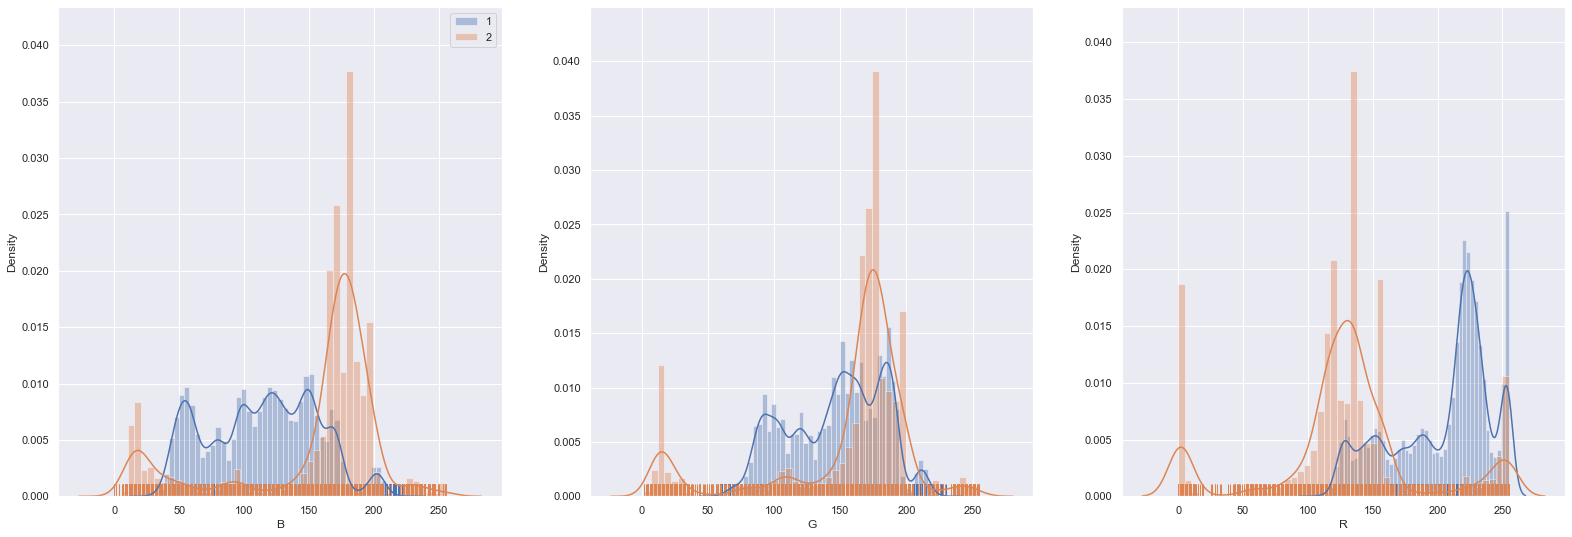

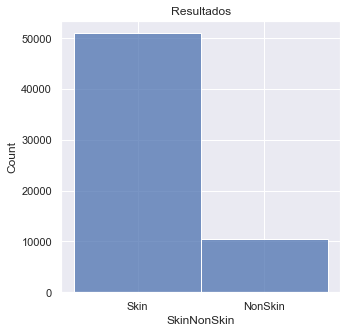

  SkinNonSkin  counts
0     NonSkin   10406
1        Skin   50858
Respecto a clase de mayor soporte: 20.46 %


In [58]:
fig, axes = plt.subplots(figsize=(9*3, 9), nrows=1, ncols=3)

for i, column in enumerate(data.columns[:-1]):
    for result in [1, 2]:
        target = data.loc[data['SkinNonSkin'] == result]
        sns.distplot(target[column], rug=True, kde=True, ax=axes[i], label=result)
    if i==0:
        axes[0].legend()

data.loc[data["SkinNonSkin"] == 1, "SkinNonSkin"] = "Skin"
data.loc[data["SkinNonSkin"] == 2, "SkinNonSkin"] = "NonSkin"

fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["SkinNonSkin"], palette="Blues_d",ax=ax, label=["Skin", "NonSkin"])
ax.set_title('Resultados')
plt.show()

gr = data.groupby(['SkinNonSkin']).size().reset_index(name='counts')
counts = list(gr.counts)
print(gr)
counts.sort()
print("Respecto a clase de mayor soporte:", round(counts[0] * 100 / counts[-1], 2), "%")

## Split

In [12]:
classes = data.columns[:-1]
X = data[classes]
y = data["SkinNonSkin"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=random_state)

y = y[:, np.newaxis]
y_train_full = y_train_full[:, np.newaxis]
y_train = y_train[:, np.newaxis]
y_val = y_val[:, np.newaxis]
y_test = y_test[:, np.newaxis]

print("X,y Shapes:", X.shape, y.shape)
print("X,y Train Full Shapes:", X_train_full.shape, y_train_full.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)
print("X,y Test Shapes:", X_test.shape, y_test.shape)

X,y Shapes: (61264, 3) (61264, 1)
X,y Train Full Shapes: (30632, 3) (30632, 1)
X,y Train Shapes: (15316, 3) (15316, 1)
X,y Val Shapes: (15316, 3) (15316, 1)
X,y Test Shapes: (30632, 3) (30632, 1)


Métrica: euclidean
	KNN peso: uniform
		Mejor K, test: 1 , acc 0.9992817968137895
		Mejor K, con K-fold (10): 2 , acc 0.999151180221463
	KNN peso: distance
		Mejor K, test: 1 , acc 0.9992817968137895
		Mejor K, con K-fold (10): 1 , acc 0.9991511375864851


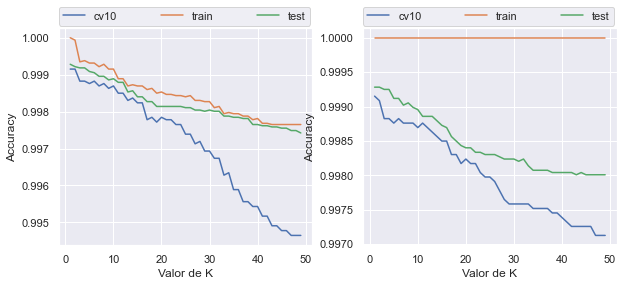



Métrica: manhattan
	KNN peso: uniform
		Mejor K, test: 1 , acc 0.9992817968137895
		Mejor K, con K-fold (10): 2 , acc 0.999085863435049
	KNN peso: distance
		Mejor K, test: 1 , acc 0.9992817968137895
		Mejor K, con K-fold (10): 2 , acc 0.9989552298622207


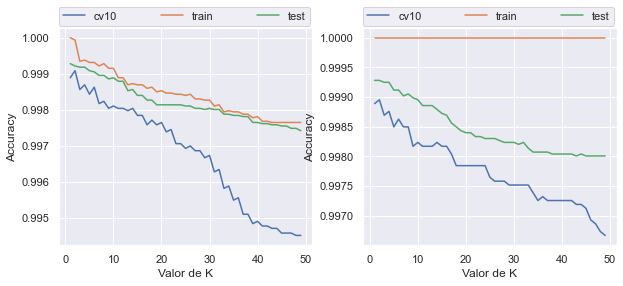



Métrica: chebyshev
	KNN peso: uniform
		Mejor K, test: 1 , acc 0.9992817968137895
		Mejor K, con K-fold (10): 2 , acc 0.9989552298622207
	KNN peso: distance
		Mejor K, test: 1 , acc 0.9992817968137895
		Mejor K, con K-fold (10): 2 , acc 0.9988899130758065


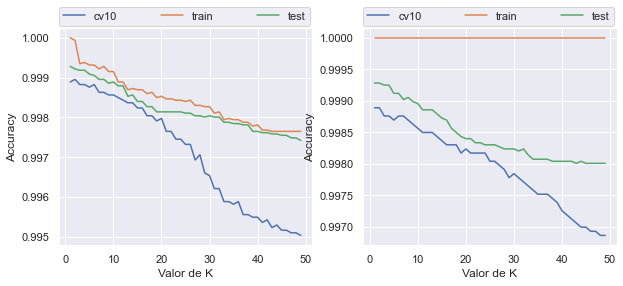

In [13]:
weights = ["uniform", "distance"]
cv = KFold(n_splits=10)

metrics = ["euclidean", "manhattan", "chebyshev"]

results = dict()

for metric in metrics:
    cv_accuracies = list([[], []])
    train_accuracies = list([[], []])
    test_accuracies = list([[], []])
    K_range = range(1, 50)

    best_acc_fold = [0] * len(weights)
    best_K_fold = [1] * len(weights)
    best_acc_test = [0] * len(weights)
    best_K_test = [0] * len(weights)

    fold_accuracy = list([[], []])
    
    results[metric] = dict()
    
    print("Métrica:", metric)
    
    for weight in range(len(weights)):
        results[metric][weights[weight]] = dict()
        for K_val in K_range:

            fold_accuracy[weight] = []
            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric=metric)

            #print("Current max depth: ", depth, "\n")

            for train_fold, valid_fold in cv.split(X_train):

                x_train_fold = X_train_full.iloc[train_fold] 
                x_val_fold = X_train_full.iloc[valid_fold] 
                y_train_fold = y_train_full[train_fold] 
                y_val_fold = y_train_full[valid_fold] 

                model.fit(x_train_fold, y_train_fold)
                valid_acc = model.score(x_val_fold, y_val_fold)
                fold_accuracy[weight].append(valid_acc)

            cv_acc = sum(fold_accuracy[weight]) / len(fold_accuracy[weight])
            cv_accuracies[weight].append(cv_acc)

            if cv_acc > best_acc_fold[weight]:
              best_acc_fold[weight] = cv_acc
              best_K_fold[weight] = K_val

            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric="euclidean")

            model.fit(X_train_full, y_train_full)

            train_acc = model.score(X_train_full,y_train_full)
            test_acc = model.score(X_test,y_test)

            if test_acc > best_acc_test[weight]:
              best_acc_test[weight] = test_acc
              best_K_test[weight] = K_val


            train_accuracies[weight].append(train_acc)
            test_accuracies[weight].append(test_acc)
            
        results[metric][weights[weight]]["K"] = best_K_fold[weight]
        results[metric][weights[weight]]["acc"] = best_acc_fold[weight]
        
        print("\tKNN peso:", weights[weight])
        print("\t\tMejor K, test:", best_K_test[weight], ", acc", best_acc_test[weight])
        print("\t\tMejor K, con K-fold (10):", best_K_fold[weight], ", acc", best_acc_fold[weight])
        
    fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

    for i in range(len(weights)):
        ax[i].plot(K_range,cv_accuracies[i],label='cv10')
        ax[i].plot(K_range,train_accuracies[i],label='train')
        ax[i].plot(K_range,test_accuracies[i],label='test')
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].set_xlabel("Valor de K")
        ax[i].set_ylabel("Accuracy")
    plt.show()
    
    print("\n")

# Precision, recall y f1-score para las 3 métricas y caso sin/con peso

In [14]:
for metric in metrics:
    print("Métrica:", metric)
    
    for weight in range(len(weights)):
        
        model = KNeighborsClassifier(n_neighbors=results[metric][weights[weight]]["K"], weights=weights[weight], metric=metric)

        model.fit(X_train, y_train)

        y_predicted = model.predict(X_val)
        
        print(weights[weight], ":")
        print(classification_report(y_val, y_predicted, target_names=["Skin", "NonSkin"]))
        print("\n")

Métrica: euclidean
uniform :
              precision    recall  f1-score   support

        Skin       1.00      1.00      1.00      2597
     NonSkin       1.00      1.00      1.00     12719

    accuracy                           1.00     15316
   macro avg       1.00      1.00      1.00     15316
weighted avg       1.00      1.00      1.00     15316



distance :
              precision    recall  f1-score   support

        Skin       1.00      1.00      1.00      2597
     NonSkin       1.00      1.00      1.00     12719

    accuracy                           1.00     15316
   macro avg       1.00      1.00      1.00     15316
weighted avg       1.00      1.00      1.00     15316



Métrica: manhattan
uniform :
              precision    recall  f1-score   support

        Skin       1.00      1.00      1.00      2597
     NonSkin       1.00      1.00      1.00     12719

    accuracy                           1.00     15316
   macro avg       1.00      1.00      1.00     15316
w

## Dataset 3: ocurre lo mismo en un dataset balanceado?

## Carga

In [48]:
data = pd.read_csv('datasets/iris.data')

data.columns = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width",
    "class"    
]

print(data.shape)

(149, 5)


## Análisis exploratorio

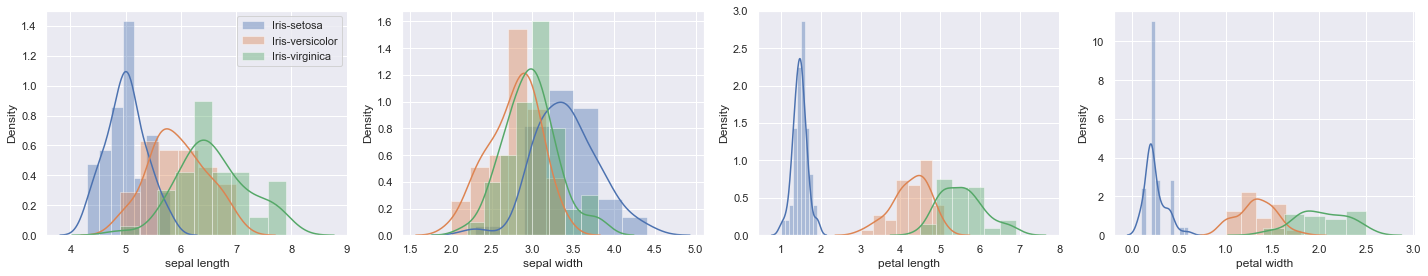

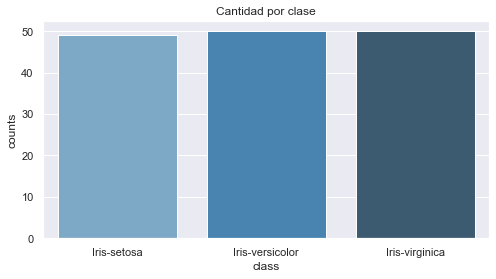

             class  counts
0      Iris-setosa      49
1  Iris-versicolor      50
2   Iris-virginica      50
Respecto a clase de mayor soporte: 98.0 %
Respecto a segunda clase de menor soporte: 98.0 %


In [49]:
classes = [
    "sepal length",
    "sepal width",
    "petal length",
    "petal width" 
]
feature = ['Iris-setosa','Iris-versicolor','Iris-virginica']

fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=4)
for i, column in enumerate(classes):
    for class_ in feature:
      target = data.loc[data['class'] == class_]
      sns.distplot(target[column], hist=True, rug=False, kde=True, ax=axes[i%4],label=class_)
      if i==0:
        axes[0].legend()

plt.tight_layout()
plt.show()

gr = data.groupby(['class']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='class', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Cantidad por clase')
plt.show()
counts = list(gr.counts)
counts.sort()
print(gr)
print("Respecto a clase de mayor soporte:", round(counts[0] * 100 / counts[-1], 2), "%")
print("Respecto a segunda clase de menor soporte:", round(counts[0] * 100 / counts[-2], 2), "%")

## Split

In [50]:
classes = data.columns[:-1]
X = data[classes]
y = data["class"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=random_state)

y = y[:, np.newaxis]
y_train_full = y_train_full[:, np.newaxis]
y_train = y_train[:, np.newaxis]
y_val = y_val[:, np.newaxis]
y_test = y_test[:, np.newaxis]

print("X,y Shapes:", X.shape, y.shape)
print("X,y Train Full Shapes:", X_train_full.shape, y_train_full.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)
print("X,y Test Shapes:", X_test.shape, y_test.shape)

X,y Shapes: (149, 4) (149, 1)
X,y Train Full Shapes: (74, 4) (74, 1)
X,y Train Shapes: (37, 4) (37, 1)
X,y Val Shapes: (37, 4) (37, 1)
X,y Test Shapes: (75, 4) (75, 1)


## Determinar K óptimo y observar accuracies

Métrica: euclidean
	KNN peso: uniform
		Mejor K, test: 9 , acc 0.9866666666666667
		Mejor K, con K-fold (10): 2 , acc 0.975
	KNN peso: distance
		Mejor K, test: 5 , acc 0.9733333333333334
		Mejor K, con K-fold (10): 3 , acc 0.975


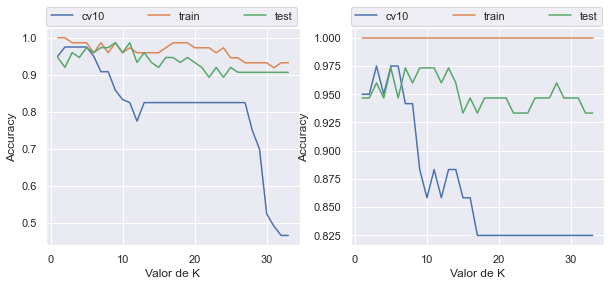



Métrica: manhattan
	KNN peso: uniform
		Mejor K, test: 9 , acc 0.9866666666666667
		Mejor K, con K-fold (10): 2 , acc 0.975
	KNN peso: distance
		Mejor K, test: 5 , acc 0.9733333333333334
		Mejor K, con K-fold (10): 3 , acc 0.975


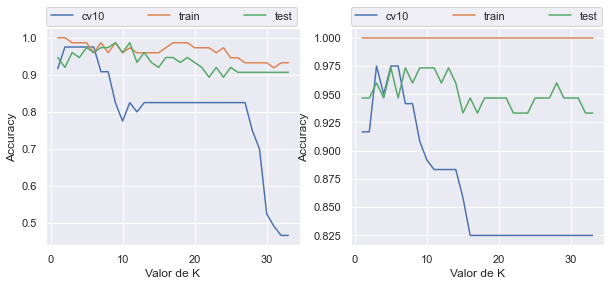



Métrica: chebyshev
	KNN peso: uniform
		Mejor K, test: 9 , acc 0.9866666666666667
		Mejor K, con K-fold (10): 5 , acc 1.0
	KNN peso: distance
		Mejor K, test: 5 , acc 0.9733333333333334
		Mejor K, con K-fold (10): 5 , acc 1.0


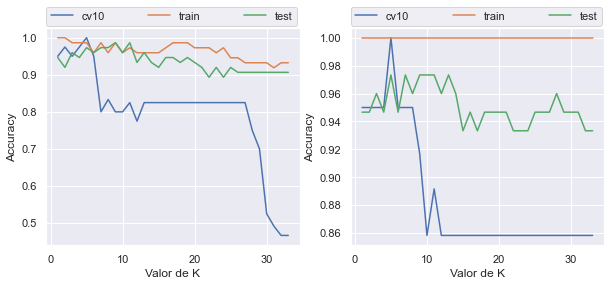

In [51]:
weights = ["uniform", "distance"]
cv = KFold(n_splits=10)

metrics = ["euclidean", "manhattan", "chebyshev"]

results = dict()

for metric in metrics:
    cv_accuracies = list([[], []])
    train_accuracies = list([[], []])
    test_accuracies = list([[], []])
    K_range = range(1, 34)

    best_acc_fold = [0] * len(weights)
    best_K_fold = [1] * len(weights)
    best_acc_test = [0] * len(weights)
    best_K_test = [0] * len(weights)

    fold_accuracy = list([[], []])
    
    results[metric] = dict()
    
    print("Métrica:", metric)
    
    for weight in range(len(weights)):
        results[metric][weights[weight]] = dict()
        
        for K_val in K_range:

            fold_accuracy[weight] = []
            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric=metric)

            for train_fold, valid_fold in cv.split(X_train):

                x_train_fold = X_train_full.iloc[train_fold] 
                x_val_fold = X_train_full.iloc[valid_fold] 
                y_train_fold = y_train_full[train_fold] 
                y_val_fold = y_train_full[valid_fold] 

                model.fit(x_train_fold, y_train_fold)
                valid_acc = model.score(x_val_fold, y_val_fold)
                fold_accuracy[weight].append(valid_acc)

            cv_acc = sum(fold_accuracy[weight]) / len(fold_accuracy[weight])
            cv_accuracies[weight].append(cv_acc)

            if cv_acc > best_acc_fold[weight]:
                best_acc_fold[weight] = cv_acc
                best_K_fold[weight] = K_val

            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric="euclidean")

            model.fit(X_train_full, y_train_full)

            train_acc = model.score(X_train_full,y_train_full)
            test_acc = model.score(X_test,y_test)

            if test_acc > best_acc_test[weight]:
                best_acc_test[weight] = test_acc
                best_K_test[weight] = K_val


            train_accuracies[weight].append(train_acc)
            test_accuracies[weight].append(test_acc)
            
        results[metric][weights[weight]]["K"] = best_K_fold[weight]
        results[metric][weights[weight]]["acc"] = best_acc_fold[weight]
        
        print("\tKNN peso:", weights[weight])
        print("\t\tMejor K, test:", best_K_test[weight], ", acc", best_acc_test[weight])
        print("\t\tMejor K, con K-fold (10):", best_K_fold[weight], ", acc", best_acc_fold[weight])
        
    fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

    for i in range(len(weights)):
        ax[i].plot(K_range,cv_accuracies[i],label='cv10')
        ax[i].plot(K_range,train_accuracies[i],label='train')
        ax[i].plot(K_range,test_accuracies[i],label='test')
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].set_xlabel("Valor de K")
        ax[i].set_ylabel("Accuracy")
        
    plt.show()
    
    print("\n")

## Precision, recall y f1-score, para todos los modelos

In [52]:
for metric in metrics:
    print("Métrica:", metric)

    for weight in range(len(weights)):        
        model = KNeighborsClassifier(n_neighbors=results[metric][weights[weight]]["K"], weights=weights[weight], metric=metric)
        model.fit(X_train, y_train)

        y_predicted = model.predict(X_val)
        
        print(weights[weight], ":")
        print(classification_report(y_val, y_predicted, target_names=feature))
        print("\n")

Métrica: euclidean
uniform :
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.83      0.91        12
 Iris-virginica       0.87      1.00      0.93        13

       accuracy                           0.95        37
      macro avg       0.96      0.94      0.95        37
   weighted avg       0.95      0.95      0.95        37



distance :
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.75      0.86        12
 Iris-virginica       0.81      1.00      0.90        13

       accuracy                           0.92        37
      macro avg       0.94      0.92      0.92        37
   weighted avg       0.93      0.92      0.92        37



Métrica: manhattan
uniform :
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-ver

# Se hace una clase desbalanceada (Iris-virginica)

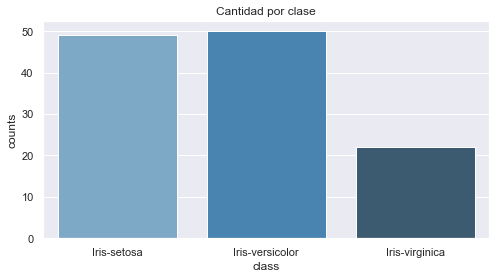

             class  counts
0      Iris-setosa      49
1  Iris-versicolor      50
2   Iris-virginica      22
Respecto a clase de mayor soporte: 44.0 %
Respecto a segunda clase de menor soporte: 44.9 %


In [53]:
data = data[0:121]

gr = data.groupby(['class']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='class', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Cantidad por clase')
plt.show()
counts = list(gr.counts)
counts.sort()
print(gr)
print("Respecto a clase de mayor soporte:", round(counts[0] * 100 / counts[-1], 2), "%")
print("Respecto a segunda clase de menor soporte:", round(counts[0] * 100 / counts[-2], 2), "%")

## Split

In [54]:
classes = data.columns[:-1]
X = data[classes]
y = data["class"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.5, random_state=random_state)

y = y[:, np.newaxis]
y_train_full = y_train_full[:, np.newaxis]
y_train = y_train[:, np.newaxis]
y_val = y_val[:, np.newaxis]
y_test = y_test[:, np.newaxis]

print("X,y Shapes:", X.shape, y.shape)
print("X,y Train Full Shapes:", X_train_full.shape, y_train_full.shape)
print("X,y Train Shapes:", X_train.shape, y_train.shape)
print("X,y Val Shapes:", X_val.shape, y_val.shape)
print("X,y Test Shapes:", X_test.shape, y_test.shape)

X,y Shapes: (121, 4) (121, 1)
X,y Train Full Shapes: (60, 4) (60, 1)
X,y Train Shapes: (30, 4) (30, 1)
X,y Val Shapes: (30, 4) (30, 1)
X,y Test Shapes: (61, 4) (61, 1)


## Determinación de K óptimo

KNN peso: uniform , métrica: euclidean
	Mejor K, test: 1 , acc 0.9672131147540983
	Mejor K, con K-fold (10): 3 , acc 0.9666666666666666
KNN peso: distance , métrica: euclidean
	Mejor K, test: 1 , acc 0.9672131147540983
	Mejor K, con K-fold (10): 3 , acc 0.9666666666666666


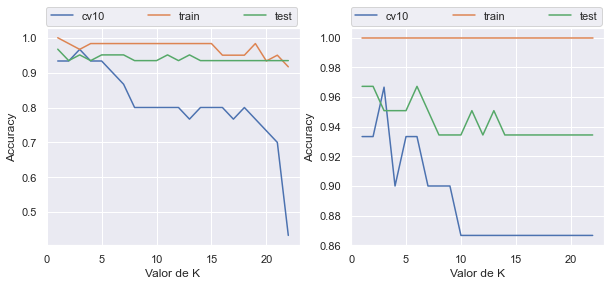



KNN peso: uniform , métrica: manhattan
	Mejor K, test: 1 , acc 0.9672131147540983
	Mejor K, con K-fold (10): 1 , acc 0.9333333333333333
KNN peso: distance , métrica: manhattan
	Mejor K, test: 1 , acc 0.9672131147540983
	Mejor K, con K-fold (10): 1 , acc 0.9333333333333333


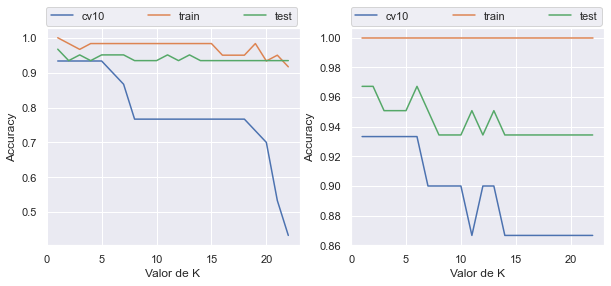



KNN peso: uniform , métrica: chebyshev
	Mejor K, test: 1 , acc 0.9672131147540983
	Mejor K, con K-fold (10): 4 , acc 0.9666666666666666
KNN peso: distance , métrica: chebyshev
	Mejor K, test: 1 , acc 0.9672131147540983
	Mejor K, con K-fold (10): 4 , acc 0.9666666666666666


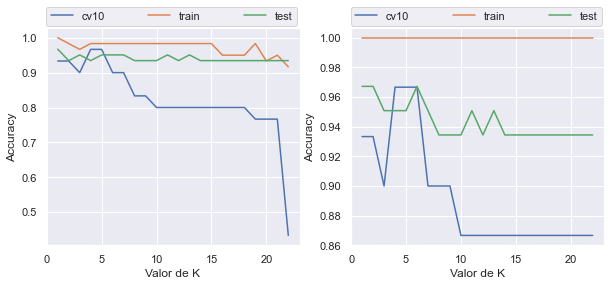

In [55]:
weights = ["uniform", "distance"]
cv = KFold(n_splits=10)

metrics = ["euclidean", "manhattan", "chebyshev"]

results = dict()

for metric in metrics:
    cv_accuracies = list([[], []])
    train_accuracies = list([[], []])
    test_accuracies = list([[], []])
    K_range = range(1, 23)

    best_acc_fold = [0] * len(weights)
    best_K_fold = [1] * len(weights)
    best_acc_test = [0] * len(weights)
    best_K_test = [0] * len(weights)

    fold_accuracy = list([[], []])
    
    results[metric] = dict()
    for weight in range(len(weights)):
        results[metric][weights[weight]] = dict()
        for K_val in K_range:

            fold_accuracy[weight] = []
            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric=metric)

            for train_fold, valid_fold in cv.split(X_train):

                x_train_fold = X_train_full.iloc[train_fold] 
                x_val_fold = X_train_full.iloc[valid_fold] 
                y_train_fold = y_train_full[train_fold] 
                y_val_fold = y_train_full[valid_fold] 

                model.fit(x_train_fold, y_train_fold)
                valid_acc = model.score(x_val_fold, y_val_fold)
                fold_accuracy[weight].append(valid_acc)

            cv_acc = sum(fold_accuracy[weight]) / len(fold_accuracy[weight])
            cv_accuracies[weight].append(cv_acc)

            if cv_acc > best_acc_fold[weight]:
              best_acc_fold[weight] = cv_acc
              best_K_fold[weight] = K_val

            model = KNeighborsClassifier(n_neighbors=K_val, weights=weights[weight], metric="euclidean")

            model.fit(X_train_full, y_train_full)

            train_acc = model.score(X_train_full,y_train_full)
            test_acc = model.score(X_test,y_test)

            if test_acc > best_acc_test[weight]:
              best_acc_test[weight] = test_acc
              best_K_test[weight] = K_val


            train_accuracies[weight].append(train_acc)
            test_accuracies[weight].append(test_acc)
            
        results[metric][weights[weight]]["K"] = best_K_fold[weight]
        results[metric][weights[weight]]["acc"] = best_acc_fold[weight]
        
        print("KNN peso:", weights[weight], ", métrica:", metric)
        print("\tMejor K, test:", best_K_test[weight], ", acc", best_acc_test[weight])
        print("\tMejor K, con K-fold (10):", best_K_fold[weight], ", acc", best_acc_fold[weight])
        
    fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

    for i in range(len(weights)):
        ax[i].plot(K_range,cv_accuracies[i],label='cv10')
        ax[i].plot(K_range,train_accuracies[i],label='train')
        ax[i].plot(K_range,test_accuracies[i],label='test')
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].legend(bbox_to_anchor=(0.0, 1.01, 0.99, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
        ax[i].set_xlabel("Valor de K")
        ax[i].set_ylabel("Accuracy")
    plt.show()
    
    print("\n")

## Métricas

In [56]:
for metric in metrics:
    print("Métrica:", metric)
    
    for weight in range(len(weights)):
        
        model = KNeighborsClassifier(n_neighbors=results[metric][weights[weight]]["K"], weights=weights[weight], metric=metric)
        model.fit(X_train, y_train)

        y_predicted = model.predict(X_val)
        
        print(weights[weight], ":")
        print(classification_report(y_val, y_predicted, target_names=feature))
        
    print("\n")

Métrica: euclidean
uniform :
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00         7

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30

distance :
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00         7

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



Métrica: manhattan
uniform :
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        13
Iris-versi